In [1]:
# standard Python packages for scientific computing:
import numpy as np  # Numerical Python
import matplotlib.pyplot as plt  # plotting
import math as m
import os  # operating system / file utilities
import sys
from timestep import *
from grid1DCartesian import *
from copy import copy
    
# from numba import jit
# first did "conda install numba".  See
# https://numba.readthedocs.io/en/stable/user/5minguide.html

In [2]:
# default figure size okay if notebook is zoomed for class presentation:
# plt.rcParams["figure.figsize"] = [6.4, 4.8] # default
plt.rcParams["figure.figsize"] = [8.0, 6.0]

In [3]:
# create a subdirectory to hold figures
# (if it doesn't exist already)
os.makedirs("../figs", exist_ok=True)

In [4]:
def init_smooth(N):
    # created the grid
    x = np.linspace(0, 1, N+1)
    x = (x[0:-1] + x[1:]) / 2
    u = np.zeros(np.size(x))
    
    # set initial conditions
    u = 1 * np.exp(- (x-0.5) ** 2 / 0.1 ** 2)
    
    return x, u

In [5]:
def init_step(N):
    # created the grid
    x = np.linspace(0, 1, N+1)
    x = (x[0:-1] + x[1:]) / 2
    u = np.zeros(np.size(x))
    
    # set initial conditions
    u = 1 * np.exp(- (x-0.3) ** 2 / 0.07 ** 2)
    where = np.where(np.abs(x-0.7) <= 0.1)[0]
    u[where] = 1

    return x, u

### Functions for shallow water wave propagation

In [6]:
# make the function name more descriptive and relevant
def find_uL_uR(x, u):
    alpha = 4
    
    u1 = (7/12 * (u + np.roll(u, -1))) - (1/12 * (np.roll(u, 1) + np.roll(u, -2)))
    
    uMPL = u + minmod(np.roll(u, -1) - u, alpha * (u - np.roll(u, 1)))
    uL = median(u1, u, uMPL)
    uMPR = np.roll(u, -1) + minmod(u - np.roll(u, -1), \
                                   alpha * (np.roll(u, -1) - np.roll(u, -2)))
    uR = median(u1, np.roll(u, -1), uMPR)
    
    return uL, uR

In [7]:
def flux_hat(h, u, b):
    f = np.array([u*h, 1/2*(u**2)+g*(h+b)])
    return f

In [8]:
def flux(x, q, b):
    c_abs = np.abs(q[1,:]) + np.sqrt(g * q[0,:])
    c_max = maxmax(c_abs, np.roll(c_abs, -1)) * 1.1
    
    hL, hR = find_uL_uR(x, q[0,:])
    uL, uR = find_uL_uR(x, q[1,:])
    
    f_hatL = flux_hat(hL, uL, b)
    f_hatR = flux_hat(hR, uR, b)
    
    f = 1/2 * (f_hatL + f_hatR) - 1/2 * np.abs(c_max) * np.array([hR - hL, uR - uL])
    return f

In [9]:
# advect 1 step
def advect_1step(x, q, b, g, t0, dt):
    # here assumes uniform grid
    dx = x[1] - x[0]
    
    w0 = q
    f0 = flux(x, w0, b)

    w1 = w0 + (dt / dx) * (- f0 + np.roll(f0, 1))
    f1 = flux(x, w1, b)
    w2 = 3/4 * w0 + 1/4 * (w1 + (dt / dx) * (- f1 + np.roll(f1, 1)))
    f2 = flux(x, w2, b)
    w3 = 1/3 * w0 + 2/3 * (w2 + (dt / dx) * (- f2 + np.roll(f2, 1)))
    q_next = w3
    
    t = t0 + dt
    
    return q_next, t

## New Run

In [10]:
# gravity acceleration
g = 1
# depth scale
b_0 = -1
# initial velocity
u_0 = 0
# number of grid points
N = 100
# intialization of profile (TODO)
x, eta = init_step(N)
eta = eta * 0.5
# bathymetry elevation relative to MSL
b = np.ones(np.size(x)) * b_0
# water depth (from bottom to water surface)
h = eta - b
# water speed
u = np.ones(np.size(x)) * u_0
# water wave speed
c = np.sqrt(g * h)

# quantity for computation
q = np.array([h, u])
q_init = q

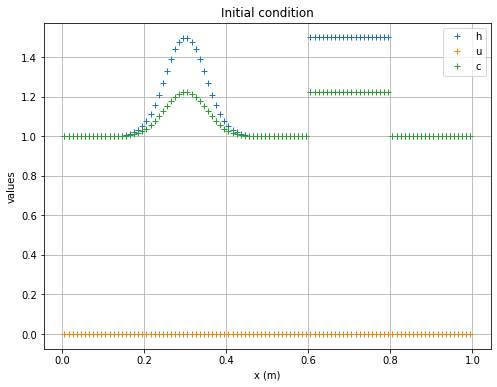

In [11]:
plt.plot(x, q[0,:], '+', label = 'h')
plt.plot(x, q[1,:], '+', label = 'u')
plt.plot(x, c, '+', label = 'c')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.title('Initial condition')
plt.show()

In [12]:
c_abs = np.abs(q[1,:]) + np.sqrt(g * q[0,:])
c_max = maxmax(c_abs, np.roll(c_abs, -1)) * 1.1

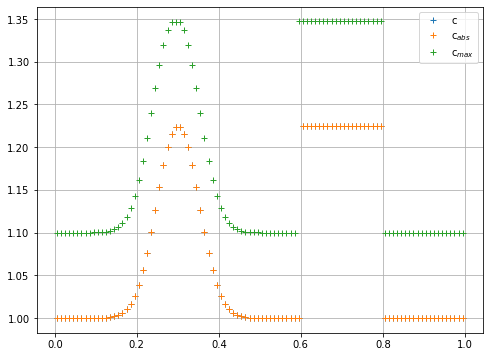

In [13]:
plt.plot(x, c, '+', label = 'c')
plt.plot(x, c_abs, '+', label = 'c$_{abs}$')
plt.plot(x, c_max, '+', label = 'c$_{max}$')
plt.grid()
plt.legend()
plt.show()

In [14]:
hL, hR = find_uL_uR(x, h)
uL, uR = find_uL_uR(x, u)

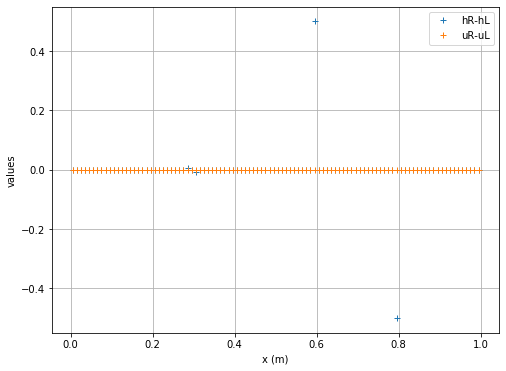

In [15]:
plt.plot(x, hR-hL, '+', label = 'hR-hL')
plt.plot(x, uR-uL, '+', label = 'uR-uL')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.show()

In [16]:
f = flux(x, q, b)

In [17]:
np.shape(f)

(2, 100)

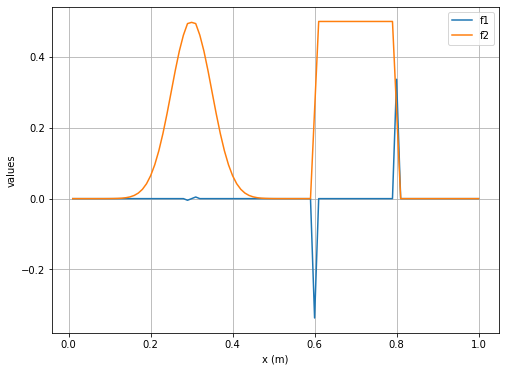

In [18]:
plt.plot(x+(x[1]-x[0])/2, f[0,:], label = 'f1')
plt.plot(x+(x[1]-x[0])/2, f[1,:], label = 'f2')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.show()

In [19]:
t0 = 0
CFL = 0.01
dx = x[1] - x[0]

q = q_init
t = t0

In [20]:
Nsteps = 1000
for ii in range(Nsteps):
    dt = CFL * dx / np.amax(np.abs(q[1,:]) + np.sqrt(g * q[0,:]))
    q, t = advect_1step(x, q, b, g, t, dt)

Text(0.5, 1.0, 't = 0.0743375 s')

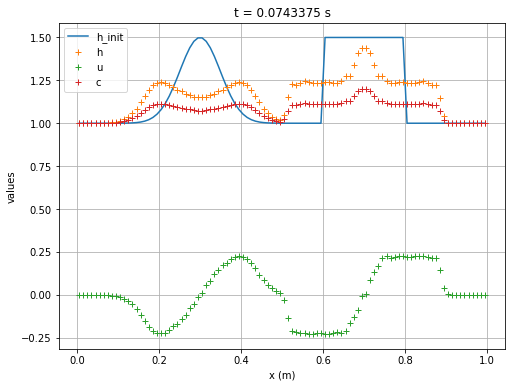

In [21]:
plt.plot(x, q_init[0,:], '-', label = 'h_init')
plt.plot(x, q[0,:], '+', label = 'h')
plt.plot(x, q[1,:], '+', label = 'u')
plt.plot(x, np.sqrt(g * q[0,:]), '+', label = 'c')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.title('t = %.7f s' % t)
#plt.show()

In [22]:
1/dt

13424.399303877799

In [23]:
dt

7.449122879644514e-05

In [24]:
c_abs = np.abs(q[1,:]) + np.sqrt(g * q[0,:])
c_max = maxmax(c_abs, np.roll(c_abs, -1)) * 1.1

hL, hR = find_uL_uR(x, q[0,:])
uL, uR = find_uL_uR(x, q[1,:])

f_hatL = flux_hat(hL, uL, b)
f_hatR = flux_hat(hR, uR, b)

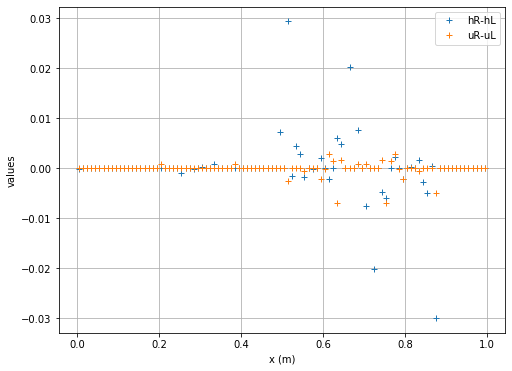

In [25]:
plt.plot(x, hR-hL, '+', label = 'hR-hL')
plt.plot(x, uR-uL, '+', label = 'uR-uL')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.show()

In [26]:
t

0.07433752441327572

In [27]:
np.sum(q_init[0,:])

116.20358847029001

In [28]:
np.sum(q[0,:])

116.20385386740838

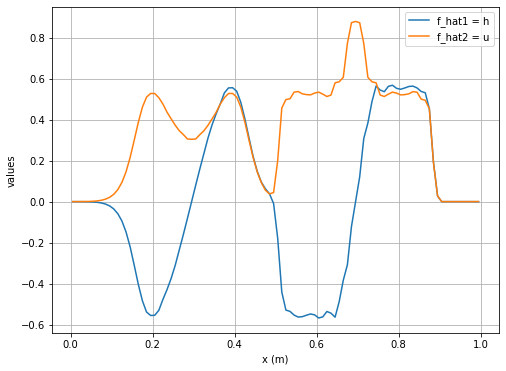

In [29]:
plt.plot(x, f_hatL[0,:] + f_hatR[0,:], label = 'f_hat1 = h')
plt.plot(x, f_hatL[1,:] + f_hatR[1,:], label = 'f_hat2 = u')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.show()

In [30]:
f = flux(x, q, b)

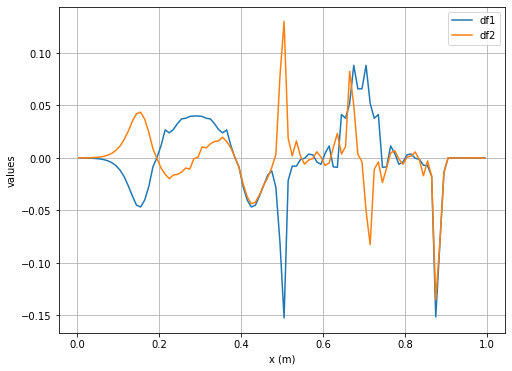

In [31]:
plt.plot(x, np.roll(f,-1)[0,:] - f[0,:], label = 'df1')
plt.plot(x, np.roll(f,-1)[1,:] - f[1,:], label = 'df2')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.show()

In [32]:
# define bathymetry
bGrid = Grid1DCartesian(0,100,200,2)
x = bGrid.get_grid('all')
b = 0.5 * np.exp(- (x-50)**2 / 5**2) - 2
bGrid.set_value(b, 'all')

In [33]:
# define initial sea level
sGrid = Grid1DCartesian(0,100,200,2)
x = sGrid.get_grid('all')
s = 0.2 * np.exp(- (x-10)**2 / 5**2)
sGrid.set_value(s, 'all')

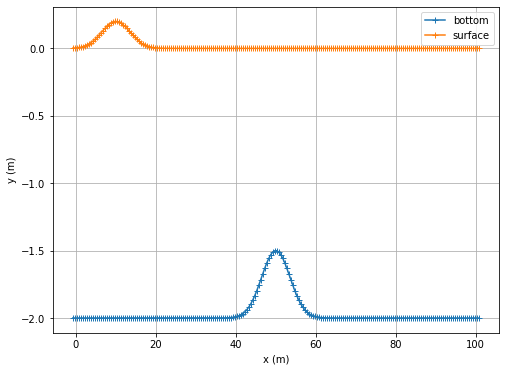

In [34]:
plt.plot(x, b, '+-', label='bottom')
plt.plot(x, s, '+-', label='surface')
plt.grid()
plt.legend()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [35]:
# define water depth
hGrid = sGrid - bGrid

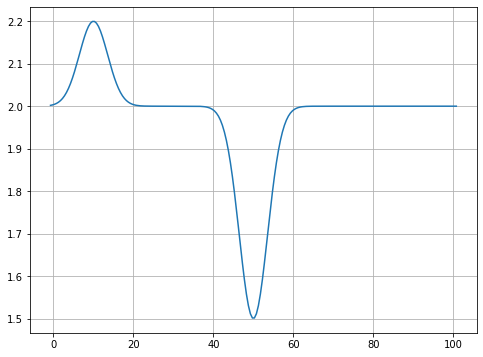

In [36]:
plt.plot(x, hGrid.get_value('all'))
plt.grid()
plt.show()

In [37]:
# define velocity
uGrid = Grid1DCartesian(0,100,200,2)
u = np.zeros(np.shape(b))
uGrid.set_value(u)

In [38]:
# define momentum
pGrid = hGrid * uGrid

In [97]:
class DummyTest():
    classtype = 'DummyTest'
    
    def __init__(self, a):
        self.a = a
        
    def get_value(self):
        return self.a
    
    def __add(self, other):
        return self.__radd__(other)
    
    def __radd__(self, other):
        if type(other) is DummyTest:
            a = other.a
        else:
            a = other
        r = DummyTest(self.a + a)
        return r
    
    def __sub__(self, other):
        return -1 * self.__rsub__(other)
    
    def __rsub__(self, other):
        if type(other) is DummyTest:
            a = other.a
        else:
            a = other
        r = DummyTest(a - self.a)
        return r
    
    def __mul__(self, other):
        return self.__rmul__(other)
    
    def __rmul__(self, other):
        if type(other) is DummyTest:
            a = other.a
        else:
            a = other
        r = DummyTest(self.a * a)
        return r
    
    def __truediv__(self, other):
        return self.__rtruediv__(other) ** (-1)
    
    def __rtruediv__(self, other):
        if type(other) is DummyTest:
            a = other.a
        else:
            a = other
        r = DummyTest(a / self.a)
        return r
    
    def __pow__(self, other):
        if type(other) is DummyTest:
            a = other.a
        else:
            a = other
        r = DummyTest(self.a ** a)
        return r
    
    def __getitem__(self, items):
        print('items = ', items)
        return self.a[items]

In [108]:
aa = DummyTest(5)
bb = DummyTest(7)

In [109]:
cc = aa * bb

In [110]:
cc.a

35

In [111]:
dd = aa ** 2
dd.a

25

In [44]:
type(2) is int

True

In [45]:
DummyTest

__main__.DummyTest

In [46]:
ds = sGrid.get_value('grid',0) - sGrid.get_value('grid',-1)

In [47]:
ds2 = s[2:202] - s[1:201]

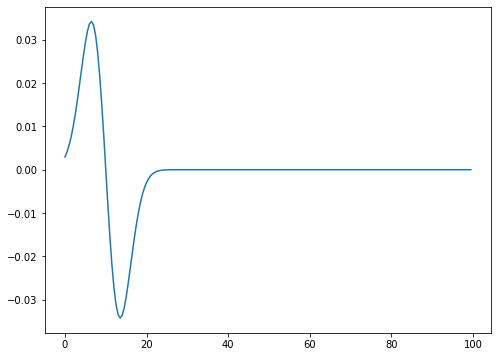

In [48]:
plt.plot((x[2:202]+x[1:201])/2, ds/(x[1]-x[0]))

In [49]:
ee = np.array([1,2,3])

In [50]:
type(ee) is np.ndarray

True

In [51]:
jj = [[1,2,3,4],[1001,1002,1003,1004],[1001,1002,1003,1004],[1001,1002,1003,1004]]
kk = np.copy(jj)
jj

[[1, 2, 3, 4],
 [1001, 1002, 1003, 1004],
 [1001, 1002, 1003, 1004],
 [1001, 1002, 1003, 1004]]

In [52]:
kk[2,2] = -1
jj

[[1, 2, 3, 4],
 [1001, 1002, 1003, 1004],
 [1001, 1002, 1003, 1004],
 [1001, 1002, 1003, 1004]]

In [58]:
3/12 ** hGrid - sGrid

TypeError: unsupported operand type(s) for ** or pow(): 'int' and 'Grid1DCartesian'

In [112]:
ff = DummyTest(np.array([[1,2,3,4],[5,6,7,8]]))
ff[1,2]

items =  (1, 2)


7

In [88]:
ss = slice(None, None, -1)

In [90]:
type(ss)

slice

In [93]:
type(ss) is slice and False

False

In [107]:
type((1,2))

tuple

In [113]:
aa_array = np.array([aa, bb, cc ,ff])

In [114]:
aa_array[1]